In [19]:
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

from np import NeuralProcess
from utils import img_to_sequence, split_context_target

In [20]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device

device(type='privateuseone', index=0)

In [21]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=10)
gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=10)

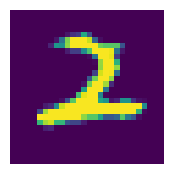

In [22]:
sample = next(iter(dataloader))

plt.figure(figsize=(2, 2))
plt.imshow(sample[0][0].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [23]:
print(sample[0].shape)
print(img_to_sequence(sample[0]).shape)
context, target = split_context_target(img_to_sequence(sample[0]), 0.6)
print(context.shape, target.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 784, 2])
torch.Size([32, 470, 2]) torch.Size([32, 314, 2])


In [24]:
context_dim = 2
r_dim = 20
z_dim = 20
h_dim = 200
in_dim = 1
out_dim = 1

model = NeuralProcess(context_dim, in_dim, out_dim, r_dim, z_dim, h_dim).to(device)
# model.load_state_dict(torch.load('vae.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [25]:
recon_criterion = nn.BCEWithLogitsLoss(reduction='mean')

def kl_criterion(mu_D, logvar_D, mu_C, logvar_C):
    k = mu_D.size(1)
    term1 = (logvar_D.exp() / logvar_C.exp()).sum(1)
    term2 = (logvar_C - logvar_D).sum(1)
    term3 = ((mu_C - mu_D).pow(2) / logvar_C.exp()).sum(1)
    return 0.5 * torch.mean(term1 + term2 + term3 - k)

# kl_criterion = nn.KLDivLoss(reduction="mean")

In [26]:
recon_losses = []
kl_losses = []

In [27]:
num_epochs = 1

torch.autograd.set_detect_anomaly(True)

model.train()
with torch.inference_mode(False):

    for epoch in range(num_epochs):

        loop = tqdm(enumerate(dataloader), total=len(dataloader))

        for step, (x, _) in loop:

            # forward
            factor = 0.5 # np.random.random()
            sequence = img_to_sequence(x).to(device)
            context, target = split_context_target(sequence, factor)

            z, mu_D, logvar_D = model.encode(sequence)
            _, mu_C, logvar_C = model.encode(context)
            # print(sequence[0][100:200])
            # print(context[0])
            # print(logvar_C[0]) #, logvar_D[0], mu_C[0], logvar_C[0])

            mu, sigma = model.decode(z, target[:, :, 0].unsqueeze(-1))

            # loss
            recon_loss = recon_criterion(mu, target[:, :, 1].unsqueeze(-1))
            kl_loss = kl_criterion(mu_D, logvar_D, mu_C, logvar_C)
            loss = recon_loss - kl_loss

            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            
            loop.set_postfix(recon_loss=recon_loss.item(), kl_loss=kl_loss.item(), loss=loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

  2%|▏         | 42/1875 [00:09<06:40,  4.57it/s, kl_loss=2.49e+5, loss=-2.49e+5, recon_loss=0.473]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
 

RuntimeError: Function 'AddmmBackward0' returned nan values in its 2th output.

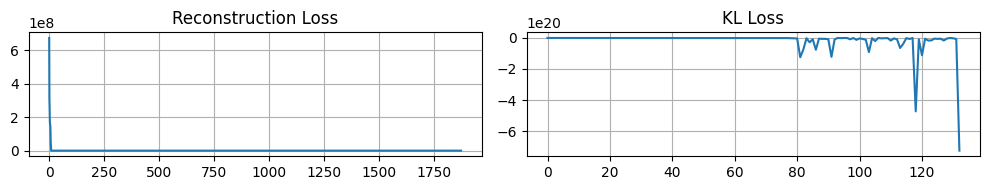

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))

ax[0].plot(recon_losses)
ax[0].set_title('Reconstruction Loss')
ax[0].grid()

ax[1].plot(kl_losses)
ax[1].set_title('KL Loss')
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
mus = []
labels = []

num_samples = 10000

for i, (x, y) in tqdm(enumerate(gen_dataloader), total=num_samples):
    mu, _ = model.encode(x.view(x.shape[0], 28 * 28).to(device))
    mus.append(mu.cpu().detach().numpy())
    labels.append(y.cpu().detach().numpy())

    if i == num_samples:
        break

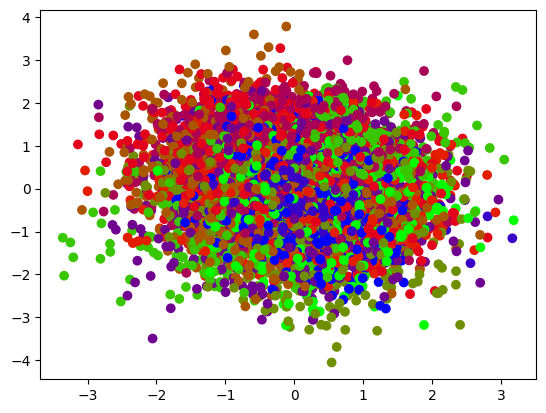

In [116]:
plt.scatter([m[0][0] for m in mus], [m[0][1] for m in mus], c=labels, cmap='brg')
plt.show()

In [25]:
torch.save(model.state_dict(), 'vae.pth')

In [12]:
def get_mu_and_logvar(model, device, digit, dataloader):

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
        for x, y in dataloader:
            if y[0] == digit:
                x = x.to(device)
                x = x.view(x.shape[0], 28 * 28)
                mu, logvar = model.encode(x)
                return mu[0], logvar[0]

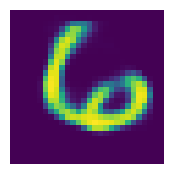

In [113]:
mu, logvar = get_mu_and_logvar(model, "cpu", 6, gen_dataloader)
sample = model.sample(mu, logvar, num_samples=1).view(28, 28).cpu().detach().numpy()

plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

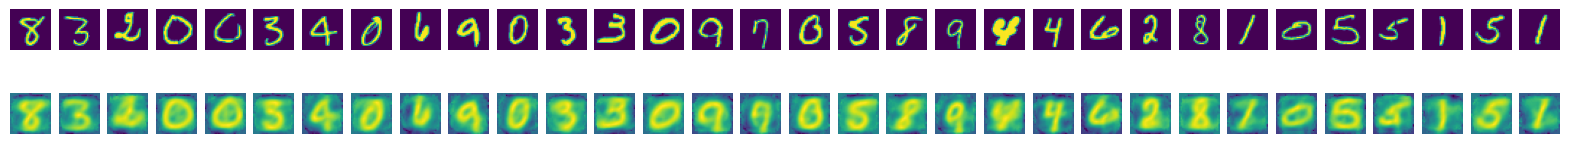

In [29]:
model = model.to(device)

input = next(iter(dataloader))[0].to(device)
recon, _, _ = model(input.view(-1, 28 * 28))

fig, ax = plt.subplots(2, input.shape[0], figsize=(20, 2))

for i in range(input.shape[0]):
    ax[0, i].imshow(input[i].view(-1, 28, 28)[0].cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(recon[i].view(-1, 28, 28)[0].cpu().detach().numpy())
    ax[1, i].axis('off')

plt.show()